In [2]:
!pip install opencv-python

# Mạng tích chập 2 chiều

In [1]:
import cv2

In [2]:
from PIL import Image

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from io import BytesIO

In [5]:
import urllib.request

In [6]:
url = str('https://imgur.com/nmGz7Lv.png')
url

'https://imgur.com/nmGz7Lv.png'

In [7]:
with urllib.request.urlopen(url) as url:
    f = BytesIO(url.read())
f

Image Shape: (1365, 2048, 3)
Image Shape: (1365, 2048, 3)


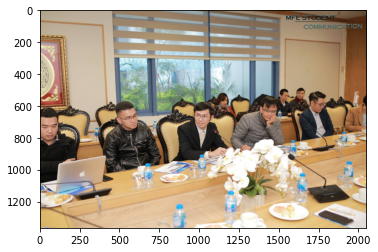

In [8]:
%matplotlib inline
X = np.array(Image.open(f))
print('Image Shape: %s'%str(X.shape))
# Convert to grey
X1 = X.dot([0.299, 0.5870, 0.114])
print('Image Shape: %s'%str(X.shape))
plt.imshow(X)

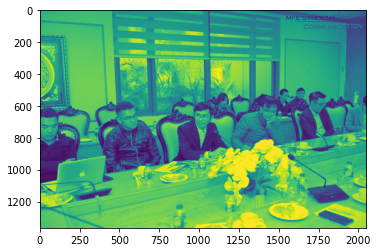

In [9]:
plt.imshow(X1)

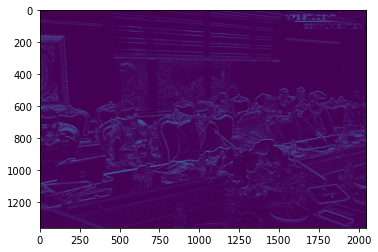

In [10]:
#Tạo bộ lọc ngang F1
F1 = np.array([[-1,-1,-1],
              [0, 0, 0],
              [1, 1, 1]])
#Tính tích chập 2 chiều:
def conv2d(X,F,s = 1, p = 0):
    """
    X: Ma trận đầu vào
    F: Ma trận bộ lọc
    s: bước trượt
    p: Độ rộng lề thêm vào
    """
    (w1,h1) = X.shape
    f = F.shape[0]
    w2 = int((w1 + 2*p - f)/s)+1
    h2 = int((h1 + 2*p - f)/s)+1
    Y = np.zeros((w2,h2))
    X_pad = np.pad(X, pad_width = p, mode = 'constant', constant_values = 0)
    for i in range(w2):
        for j in range(h2):
            idw = i*s
            idh = j*s
            Y[i, j] = np.abs(np.sum(X_pad[idw:(idw+f), idh:(idh+f)]*F))
    return Y
Y1 = conv2d(X1, F1, s = 1, p = 0)
plt.imshow(Y1)

Ta nhận thấy bộ lọc trên có tác dụng nhận diện những đường nét theo chiều ngang của bức ảnh như các đường viền của cửa sổ, cạnh bàn, vai áo,…. Sở dĩ bộ lọc này làm nổi bật các đường nét nằm ngang là bởi vì tích chập của chúng bằng hiệu của tổng giá trị các điểm phía dưới trừ các điểm phía trên. Đối với các đường nét nằm ngang thì cường độ sáng ít thay đổi theo phương ngang nhưng xét theo chiều dọc thì chúng sẽ thay đổi. Do đó hiệu giữa 2 tổng phía trên và dưới càng lớn dẫn tới giá trị của tích chập càng lớn khi trượt theo các đường nét nằm ngang này. Khi hoàn thành thiện ma trận tích chập các đường nét nằm ngang sẽ có cường độ sáng lớn hơn nên nổi bật hơn. Chúng ta sẽ thử nghiệm một bộ lọc khác để nhận diện chiều dọc của bức ảnh.

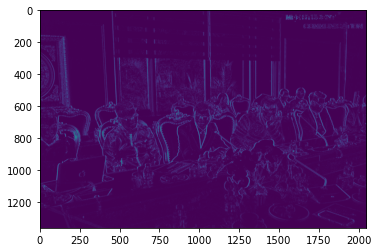

In [11]:
#Tạo bộ lọc dọc F2
F2 = np.array([[1, 0, -1],
              [1, 0, -1],
              [1, 0, -1]])
Y2 = conv2d(X1,F2,s = 1, p = 0)
plt.imshow(Y2)

# Mạng nơron Tích chập (CNN)

* **Đơn vị (Unit)**: Là giá trị của một điểm nằm trên ma trận khối ở mỗi tầng của mạng CNN.

* **Vùng nhận thức** (Receptive Field): Là một vùng ảnh trên khối ma trận đầu vào mà bộ lọc sẽ nhân tích chập để ánh xạ tới một đơn vị trên layer tiếp theo.

* **Vùng địa phương** (Local region): Theo một nghĩa nào đó sẽ bao hàm cả vùng nhận thức. Là một vùng ảnh cụ thể nằm trên khối ma trận ở các tầng (layer) của mạng CNN.

* **Bản đồ đặc trưng** (Feature Map): Là ma trận đầu ra khi áp dụng phép tích chập giữa bộ lọc với các vùng nhận thức theo phương di chuyển từ trái qua phải và từ trên xuống dưới.

* **Bản đồ kích hoạt** (Activation Map): Là output của bản đồ đặc trưng CNN khi áp dụng thêm hàm activation để tạo tính phi tuyến.

Tích chập được ứng dụng phổ biến trong lĩnh vực thị giác máy tính. Thông qua các phép tích chập, các đặc trưng chính từ ảnh được trích xuất và truyền vào các tầng tích chập (layer convolution). Mỗi một tầng tích chập sẽ bao gồm nhiều đơn vị mà kết quả ở mỗi đơn vị là một phép biến đổi tích chập từ layer trước đó thông qua phép nhân tích chập với bộ lọc.

Về cơ bản thiết kế của một mạng nơ ron tích chập 2 chiều có dạng như sau:

$INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC$

Trong đó:

* INPUT: Tầng đầu vào

* CONV: Tầng tích chập

* RELU: Tầng kích hoạt. Thông qua hàm kích hoạt (activation function), thường là ReLU hoặc LeakyReLU để kích hoạt phi tuyến

* POOL: Tầng tổng hợp, thông thường là Max pooling hoặc có thể là Average pooling dùng để giảm chiều của ma trận đầu vào.

* FC: Tầng kết nối hoàn toàn. Thông thường tầng này nằm ở sau cùng và kết nối với các đơn vị đại diện cho nhóm phân loại.

Các kí hiệu []N, []M hoặc []*K ám chỉ các khối bên trong [] có thể lặp lại nhiều lần liên tiếp nhau. M, K là số lần lặp lại. Kí hiệu -> đại diện cho các tầng liền kề nhau mà tầng đứng trước sẽ làm đầu vào cho tầng đứng sau. Dấu ? sau POOL để thể hiện tầng POOL có thể có hoặc không sau các khối tích chập.

Như vậy ta có thể thấy một mạng nơ ron tích chập về cơ bản có 3 quá trình khác nhau:

* Quá trình tích chập (convolution): Thông qua các tích chập giữa ma trận đầu vào với bộ lọc để tạo thành các đơn vị trong một tầng mới. Quá trình này có thể diễn ra liên tục ở phần đầu của mạng và thường sử dụng kèm với hàm kích hoạt ReLU. Mục tiêu của tầng này là trích suất đặc trưng hai chiều.


* Quá trình tổng hợp (max pooling): Các tầng càng về sau khi trích xuất đặc trưng sẽ cần số lượng tham số lớn do chiều sâu được qui định bởi số lượng các kênh ở các tầng sau thường tăng tiến theo cấp số nhân. Điều đó làm tăng số lượng tham số và khối lượng tính toán trong mạng nơ ron. Do đó để giảm tải tính toán chúng ta sẽ cần giảm kích thước các chiều của khối ma trận đầu vào hoặc giảm số đơn vị của tầng. Vì mỗi một đơn vị sẽ là kết quả đại diện của việc áp dụng 1 bộ lọc để tìm ra một đặc trưng cụ thể nên việc giảm số đơn vị sẽ không khả thi. Giảm kích thước khối ma trận đầu vào thông qua việc tìm ra 1 giá trị đại diện cho mỗi một vùng không gian mà bộ lọc đi qua sẽ không làm thay đổi các đường nét chính của bức ảnh nhưng lại giảm được kích thước của ảnh. Do đó quá trình giảm chiều ma trận được áp dụng. Quá trình này gọi là tổng hợp nhằm mục đích giảm kích thước dài, rộng.


* Quá trình kết nối hoàn toàn (fully connected): Sau khi đã giảm kích thước đến một mức độ hợp lý, ma trận cần được trải phẳng (flatten) thành một vector và sử dụng các kết nối hoàn toàn giữa các tầng. Quá trình này sẽ diễn ra cuối mạng CNN và sử dụng hàm kích hoạt là ReLU. Tầng kết nối hoàn toàn cuối cùng (fully connected layer) sẽ có số lượng đơn vị bằng với số classes và áp dụng hàm kích hoạt là softmax nhằm mục đích tính phân phối xác xuất.

# Xây dựng mạng Neuron Tích chập

In [13]:
import tensorflow as tf 
print(tf.__version__)

2.7.0


In [14]:
import tensorflow as tf
import absl

In [19]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#tf.logging.set_verbosity(tf.logging.INFO)

def cnn_model_fn(features, labels, mode):
    """Model function for CNN"""
    #Input layer
    input_layer = tf.reshape(features['x'], shape = [-1, 28, 28, 1])
    
    #Convolution layer 1
    conv1 = tf.layers.conv2d(
        inputs = input_layer,
        filters = 32,
        kernel_size = [5, 5],
        padding = 'same',
        activation = tf.nn.relu)
    #Apply formula:N1 = (N+2P-f)/S + 1
    #in which: N is input image size, P is padding size, f is filter size and S is step
    #Output tensor shape: N1 = (28-5)/1+1 = 24 => shape = [-1, 24, 24, 1]
    #But we at parameter we set padding = 'same' in order to keep output shape unchange to input shape 
    #Thus output shape is [-1, 28, 28, 1]
    
    #Max pooling layer 1
    pool1 = tf.layers.max_pooling2d(
        inputs = conv1, 
        pool_size = [2, 2],
        strides = 2)
    #Output tensor shape: N2 = (28-2)/2+1 = 14 => shape = [-1, 14, 14, 1]
    
    #Convolution layer 2
    conv2 = tf.layers.conv2d(
        inputs = pool1,
        filters = 64,
        kernel_size = [5, 5],
        padding = 'same',
        activation = tf.nn.relu)
    #Output tensor shape: N3 = (14-5)/1+1 = 10 => shape = [-1, 10, 10, 1]
    #But padding = 'same' so output shape is [-1, 14, 14, 1]
    
    #Max pooling layer 2
    pool2 = tf.layers.max_pooling2d(
        inputs = conv2,
        pool_size = [2, 2],
        strides = 2)
    #Output tensor shape: N4 = (14-2)/2+1 = 7 => shape = [-1, 7, 7, 1]
    
    #Dense layer
    flat = tf.reshape(pool2, [-1, 7*7*64])
    dense = tf.layers.dense(
        inputs = flat, 
        units = 1024,
        activation = tf.nn.relu)
    
    dropout = tf.layers.dropout(
        inputs = dense,
        rate = 0.4,
        training = mode == tf.estimator.ModeKeys.TRAIN)
    
    #Logits layer
    logits = tf.layers.dense(inputs = dropout, units = 10)
    
    predictions = {
        'classes': tf.argmax(input = logits, axis = 1, name = 'class_tensor'),
        'probabilities': tf.nn.softmax(logits, name = 'softmax_tensor')}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)

    loss = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
        train_op = optimizer.minimize(
            loss = loss, 
            global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss = loss, train_op = train_op)
    
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            'accuracy': tf.metrics.accuracy(
            labels = labels, predictions = predictions['classes'])}
        return tf.estimator.EstimatorSpec(
            mode = mode, loss = loss, eval_metric_ops = eval_metric_ops)

In [20]:
import sys


In [21]:
from mnist import MNIST
mndata = MNIST('../input')
mndata.load_training()
train_data = np.asarray(mndata.train_images)/255.0
train_labels = np.array(mndata.train_labels.tolist())

mndata.load_testing()
test_data = np.asarray(mndata.test_images)/255.0
test_labels = np.array(mndata.test_labels.tolist())

print('Train images shape      : %s'%str(train_data.shape))
print('Train labels shape shape: %s'%str(train_labels.shape))
print('Test  images shape      : %s'%str(test_data.shape))
print('Test  labels shape shape: %s'%str(test_labels.shape))


FileNotFoundError: [Errno 2] No such file or directory: '../input\\train-labels-idx1-ubyte'

In [22]:
#Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn = cnn_model_fn, 
    model_dir = './tmp/conv2_checkpoints' #temporary file to save model
)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmp/conv2_checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [23]:
#Training model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'x': train_data},
    y = train_labels, 
    batch_size = 100,
    num_epochs = 50,
    shuffle = True
)

AttributeError: module 'tensorflow_estimator.python.estimator.api._v2.estimator' has no attribute 'inputs'

In [24]:
mnist_classifier.train(
    input_fn = train_input_fn,
    steps = 10000
#     hooks = [logging_hook]
)

NameError: name 'train_input_fn' is not defined